# The aim of this short code is to demonstrate that in the limit of very large size of a neural network the output distribution of data is Gaussian.
We use a very simple forward NN with a single hidden layer.

If we use as input gaussian distributions with Mu=0 and STD=1 and we define the STD of the output layer as STD/hidden_size, then the minimum number of necessary neurons to have a final gaussian distribution is 3 (hidden_size = 3).

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import normaltest
from scipy.stats import norm
from scipy.optimize import curve_fit
import math

In [56]:
def initialization(input_size_, hidden_size_, Mu_, STD_, nl):
    bname = 'b{}'.format(nl)
    Wname = 'W{}'.format(nl)
    WR = tf.Variable(tf.random.normal([input_size_, hidden_size_], mean=Mu_, stddev=STD_), name=Wname)
    BR = tf.Variable(tf.random.normal([hidden_size_], mean=Mu_, stddev=STD_), name=bname)
    return WR,BR

# Define the forward function to compute the output of the neural network
# You can choose the activation you prefer
def forward(X, i, activation):
    with tf.GradientTape() as tape:
        tape.watch([Ws[i,0], Bs[i,0], Ws[i,1], Bs[i,1], Ws[i,2], Bs[i,2], Ws[i,3], Bs[i,3], Ws[i,4], Bs[i,4]])  # It registers the parameters inside the GradientTape
        Z1 = tf.add(tf.matmul(X, Ws[i,0]), Bs[i,0])
        A1 = activation(Z1)
        Z2 = tf.add(tf.matmul(A1, Ws[i,1]), Bs[i,1])
        A2 = activation(Z2)
        Z3 = tf.add(tf.matmul(A2, Ws[i,2]), Bs[i,2])
        A3 = activation(Z3)
        Z4 = tf.add(tf.matmul(A3, Ws[i,3]), Bs[i,3])
        A4 = activation(Z4)
        Z5 = tf.add(tf.matmul(A4, Ws[i,4]), Bs[i,4])
       
    gradients = tape.gradient(Z5, [Ws[i,0], Bs[i,0], Ws[i,1], Bs[i,1], Ws[i,2], Bs[i,2], Ws[i,3], Bs[i,3], Ws[i,4], Bs[i,4]])
    return Z5, gradients

def bootobj_extr(layer_, el1_, el2_):
    A = np.zeros(Nboot)
    B = np.zeros(Nboot)
    for i in range(Nboot):
        matrW = Ws[i, layer_]
        A[i] = matrW[el1_, el2_]
        vecB = Bs[i,layer_]
        B[i] = vecB[el1_]
    return A,B

def data_law(x_):
    return math.sin(x_)

#Bootstrap Mean and Sigma
def mean(arr):
    return sum(arr)/len(arr)
def std_dev(arr):
    arr_mean = mean(arr)
    return (sum([(i - arr_mean)**2 for i in arr]) / (len(arr)-1))**0.5

In [4]:
# Define the dimensions of the NN
input_size = 1
hidden_size = 3
output_size = 1
depth = 5
Nboot = 100
lsizes = np.concatenate(([input_size], np.repeat(hidden_size, depth-1), [output_size]))
print(lsizes)

#Define parameters of the Gaussian distribution
STD = 1
Mu = 0


#Weights and biases generation
Ws = np.empty((Nboot, depth), dtype=object)  # Array vuoto per le matrici W
Bs = np.empty((Nboot, depth), dtype=object)  # Array vuoto per i vettori b

#The output is a np array of tf objects
for i in range(Nboot):
    for l in range(depth):
        Ws[i, l], Bs[i, l] = initialization(lsizes[l], lsizes[l+1], Mu, STD / lsizes[l], l)
        #if(i==1): print(lsizes[l], lsizes[l+1], lsizes[l])
        
    
# We compute the output for each event for an input
X = tf.constant([[30]], dtype=tf.float32)
output_array = []
grads_array = np.array([])
for i in range (0, Nboot):
        
    Y, Grad = forward(X,i,tf.nn.relu)
    grads_np = np.concatenate([g.numpy().flatten() for g in Grad])  # Flattening e concatenation of derivatives
    grads_array = np.vstack([grads_array, grads_np]) if grads_array.size else grads_np
    output_array.append(Y.numpy()[0][0])

print(grads_array.shape)

[1 3 3 3 3 1]
(100, 46)


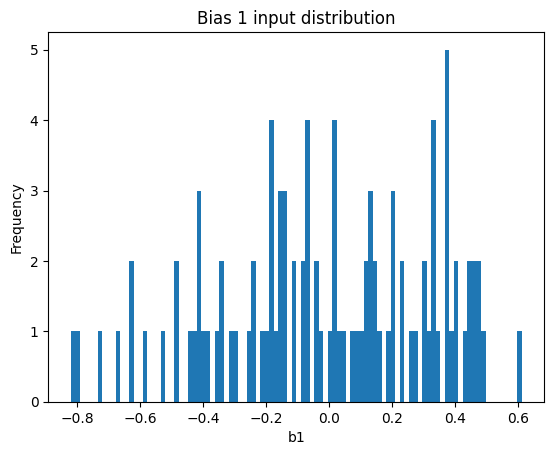

Data follow a gaussian distribution.


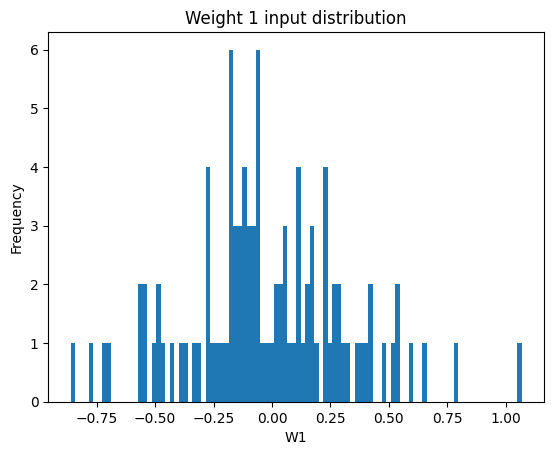

<Figure size 640x480 with 0 Axes>

In [5]:
Whist, Bhist = bootobj_extr(1,1,1)


# Print the input distributions of the weights and bias
#print(b1.numpy()[0,:])
plt.hist(Bhist, bins=100)
plt.xlabel('b1')
plt.ylabel('Frequency')
plt.title('Bias 1 input distribution')
plt.savefig('Bias1.png')
plt.show()

# Test of the gaussianity
stat, p = normaltest(Bhist)

# Print the result of the test
if p < 0.05:
    print("Data don't follow a gaussian distribution.")
else:
    print("Data follow a gaussian distribution.")

plt.clf()


plt.hist(Whist, bins=100)
plt.xlabel('W1')
plt.ylabel('Frequency')
plt.title('Weight 1 input distribution')
plt.show()

plt.clf()



No gaussian distribution.


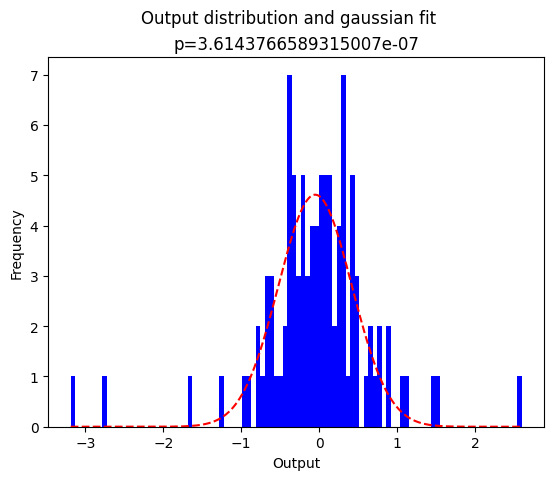

Mean: -0.05225397355526565
Standard deviation: -0.4720288034996353
Amplitude: 4.614265542349428


In [6]:
# Test of the gaussianity
stat, p = normaltest(output_array)

# Print the result of the test
if p < 0.05:
    string = "No gaussian distribution." 
    print(string)
else:
    string = "Gaussian distribution."
    print(string)

# Take parameters of our histogram
counts, bins, _ = plt.hist(output_array, bins=100)

ylim = max(counts)-10
xlim = min(bins)
xlim2 = max(bins)

# Define the Gaussian function
def gaussian(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))


# Plot the histogram and the fitted Gaussian function
plt.clf()
x = np.linspace(xlim, xlim2, 1000)
plt.hist(output_array, bins=100, color ='blue')
plt.xlabel('Output')
plt.ylabel('Frequency')
plt.suptitle('Output distribution and gaussian fit')
plt.title('p='+ str(p))
p0 = [(xlim+xlim2)/2, xlim2-xlim, 1]
coeff, var_matrix = curve_fit(gaussian, bins[:-1], counts, p0=p0)
plt.plot(x, gaussian(x, *coeff), 'r--', label='fit')    
    
#plt.text(xlim-3, ylim, 'L='+ str(hidden_size), fontsize=18)
#plt.text(xlim-3, ylim, string, fontsize=8)
plt.savefig('Output.png')
plt.show()

# Print gaussian parameters
print("Mean:", coeff[0])
print("Standard deviation:", coeff[1])
print("Amplitude:", coeff[2])

In [10]:
#Theta computation
theta = np.zeros(Nboot)
for iboot in range(Nboot):
    for j in range(46):
        theta[iboot] = sum(grads_array[iboot,i]**2 for i in range(46))
#print(grads_array[1,:],grads_array.T[1,:])
print(theta)

[  1.2466591    1.68804929   2.81917509   2.6754228    1.
 245.5214982   10.02010594   1.5620718    1.           1.81570813
  19.74949879  20.55611442   1.10957134   1.15963999   1.25822801
  15.75318265   1.05061734   1.18413554   7.81515997   2.48971127
   5.21296074   7.49489019  43.74419747   1.15711924 200.06059454
   2.7368809    1.14807353   1.35759046   1.46418699 411.90774174
   4.51217977   1.14833303   1.04730097   1.5135483    7.18249471
   1.7391369    2.17012899   1.         181.91472371  45.9925137
 281.22020918   1.           1.           1.          20.4698667
   1.90617601  41.08478153   1.06979631   1.           1.48782696
 270.48805395   1.148545     2.58880605  34.38368781   1.14032891
   1.00593444 107.89049454   2.96079392   1.09389162   1.26681709
  14.01648498   1.0824069    9.13724584   1.02777457  11.14138975
   1.           1.44947681   1.32424177  28.38496976 130.83597578
   2.10703607  19.93157909  40.27785101   1.           1.34887182
   1.53254958   1.79

In [18]:
def Train(grad_, theta_, eta_, t_, output_, Y_):
    omega_t = -grad_/theta_*(1-math.exp(-eta_*theta_*t_))*(output_ - Y_)
    f_lin = (1-math.exp(-eta_*theta_*t_))*Y_ + math.exp(-eta_*theta_*t_)*output_
    return omega_t, f_lin

def Ver(x_, theta_, t_, Y_, i_, output_):
    mu_t = theta_*theta^(-1)*(1-math.exp(-eta_*theta_*t_))*Y_
    gamma_t = forward(x_,i,tf.nn.relu) - theta*theta^(-1)*(1-math.exp(-eta_*theta_*t_))*output_
    
print(len(output_array))

100


-0.9880316240928618 (100, 46)
(100, 75) [[-0.4374918  -0.60927208 -0.72745321 ... -0.98803162 -0.98803162
  -0.98803162]
 [-0.38297689 -0.62339397 -0.76828188 ... -0.98803162 -0.98803162
  -0.98803162]
 [ 0.14527819 -0.50157626 -0.77922833 ... -0.98803162 -0.98803162
  -0.98803162]
 ...
 [ 1.11126387 -0.98803162 -0.98803162 ... -0.98803162 -0.98803162
  -0.98803162]
 [ 1.48500955 -0.98803162 -0.98803162 ... -0.98803162 -0.98803162
  -0.98803162]
 [ 0.32908741 -0.37099177 -0.6989627  ... -0.98803162 -0.98803162
  -0.98803162]]
(75,) [-0.03446251 -0.57256369 -0.71680884 -0.80456376 -0.86170294 -0.90002197
 -0.92619471 -0.94430339 -0.95695304 -0.96585415 -0.97215351 -0.97663209
 -0.97982815 -0.98211612 -0.98375837 -0.98493985 -0.98579152 -0.98640654
 -0.98685136 -0.98717353 -0.98740717 -0.9875768  -0.98770008 -0.98778977
 -0.98785507 -0.98790266 -0.98793736 -0.98796269 -0.98798119 -0.9879947
 -0.98800458 -0.98801181 -0.9880171  -0.98802097 -0.98802381 -0.98802589
 -0.98802742 -0.98802853 

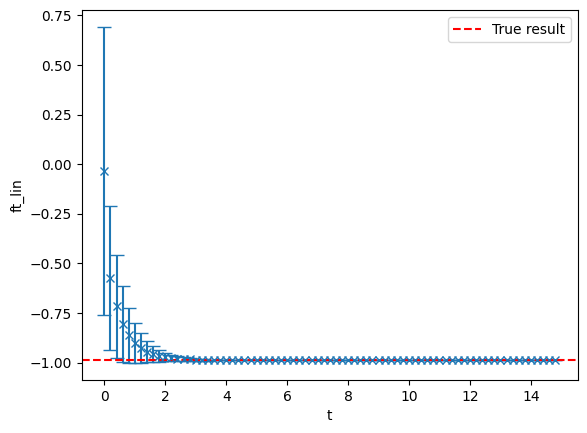

In [70]:
Y = data_law(30.)
print(Y, grads_array.shape)

#omega = []
Bins = np.arange(0,15,0.2)
flin_tr = np.empty((Nboot, len(Bins)))

for i in range(Nboot):
    for j in range(len(Bins)):
        _, flin_tr_app = Train(grads_array[i,:],theta[i], 0.3, j, output_array[i], Y)
        flin_tr[i,j] = flin_tr_app

#print(omega[1])
print(flin_tr.shape, flin_tr)

flin_tr_mu = np.empty(len(Bins))
flin_tr_s = np.empty(len(Bins))


for i in range(len(Bins)):
    flin_tr_mu[i] = mean(flin_tr[:,i])
    flin_tr_s[i] = std_dev(flin_tr[:,i])
    
print(flin_tr_mu.shape, flin_tr_mu)


plt.errorbar(Bins, flin_tr_mu, yerr=flin_tr_s, fmt='x', capsize=5)
plt.axhline(Y, color='r', linestyle='--', label='True result')
plt.legend()
plt.xlabel('t')
plt.ylabel('ft_lin')
plt.show()